In [1]:
%matplotlib inline
from copy import deepcopy as copy
from itertools import product as c_product
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
from scipy import stats

from aux import nansem
from disp import set_font_size
from lin_fit import fit_h


EXPT = 'CL_360_LOWFLOW_ACV'
# EXPT = 'CL_180_HighFlow_ACV'

TARGS = ['G2', 'G3', 'G4', 'G5']
SRCS = ['Odor', 'AbsHeading', 'ForVel']
NORMED_COLS = ['G2', 'G3', 'G4', 'G5']

COLORS = {
    'G2': 'b', 'G3': 'r', 'G4': 'g', 'G5': 'm',
    'Motion': (1, .5, 0), 'ForVel': 'k', 'AbsAngVel': 'y', 'AbsHeading': 'c', 
}

DT = 0.1
CTL_T_OFFSET = 0  #-20

DATA_DIR = os.path.join('data_', EXPT)
SAVE_DIR = os.path.join('data_', '_RESULTS', 'ODOR_TRIG', 'tmp')

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

# Load data and normalize

In [2]:
base = 'clean.csv'
mvng = 'moving.csv'
mvng_cols = ['Start', 'Stop']
odor = 'odor_times.csv'
odor_cols = ['Odor_On', 'Odor_Off', 'Include']

trials = []
pulses = []
odor_masks = []
mvng_masks = []
data_u = {}  # unnormalized data
data_n = {}  # normalized data
d_mvng = {}  # dfs of moving times
d_odor = {}  # dfs of odor times

for fly in os.listdir(DATA_DIR):
    fly_path = os.path.join(DATA_DIR, fly)
    
    for trial in os.listdir(fly_path):
        trial_path = os.path.join(fly_path, trial)
        
        # load data
        data_u_ = pd.read_csv(os.path.join(trial_path, base))
        
        # store relevant columns
        data_u_ = data_u_[['Time', 'G2_avg', 'G3_avg', 'G4_avg', 'G5_avg', 'ForVel', 'AngVel', 'AbsHeading', 'Motion']]
        data_u_['AbsAngVel'] = np.abs(data_u_['AngVel'])
        data_u_['AbsHeading'] = data_u_['AbsHeading']
        
        # make odor mask
        df_odor = pd.read_csv(os.path.join(trial_path, odor))
        if EXPT == 'CL_180_HighFlow_ACV':
            df_odor[odor_cols[1]] = 150
        df_odor[odor_cols[0]] += CTL_T_OFFSET
        df_odor[odor_cols[1]] += CTL_T_OFFSET
        
        odor_mask = np.zeros(len(data_u_['Time']), dtype=bool)
        starts = df_odor[odor_cols[0]]
        stops = df_odor[odor_cols[1]]
        includes = df_odor[odor_cols[2]]
        
        for ctr, (start, stop, include) in enumerate(zip(starts, stops, includes)):
            odor_mask[(start <= data_u_['Time']) & (data_u_['Time'] < stop)] = True
            # add to pulse dict
            if include:
                pulses.append(
                    {'Fly': fly, 'Trial': trial, 'Pulse': ctr, 'Start': start, 'Stop': stop, 'Include': include})
            
        data_u_['Odor'] = odor_mask.astype(float)
        odor_masks.append(odor_mask.copy())
        
        # make moving mask
        df_mvng = pd.read_csv(os.path.join(trial_path, mvng))
        starts = df_mvng[mvng_cols[0]]
        stops = df_mvng[mvng_cols[1]]
        mvng_mask = np.zeros(len(data_u_['Time']), dtype=bool)
        
        for start, stop in zip(starts, stops):
            mvng_mask[(start <= data_u_['Time']) & (data_u_['Time'] < stop)] = True
            
        mvng_masks.append(mvng_mask.copy())
            
        data_u_['Mvng'] = mvng_mask
        
        data_u_ = data_u_.rename(columns={'G2_avg': 'G2', 'G3_avg': 'G3', 'G4_avg': 'G4', 'G5_avg': 'G5'})
        
        # normalize data
        data_n_ = data_u_.copy()
        data_n_[NORMED_COLS] -= data_n_[NORMED_COLS].mean()
        data_n_[NORMED_COLS] /= data_n_[NORMED_COLS].std()
        
        # normalize motion, for-, and angvel to median walking speed
        median_walk_speed = np.nanmedian(data_n_['Motion'][mvng_mask])
        data_n_['Motion'] /= median_walk_speed
        data_n_['ForVel'] /= median_walk_speed
        data_n_['AngVel'] /= median_walk_speed
        data_n_['AbsAngVel'] /= median_walk_speed
        
        # store all results
        data_u[trial] = data_u_
        data_n[trial] = data_n_
        d_mvng[trial] = df_mvng
        d_odor[trial] = df_odor
        
        trials.append(trial)
        
df_pulse = pd.DataFrame(data=pulses, columns=['Fly', 'Trial', 'Pulse', 'Start', 'Stop', 'Include'])

n_fly = len(os.listdir(DATA_DIR))
n_trial = len(trials)
n_pulse = len(df_pulse)

print('{} FLIES, {} TRIALS, {} PULSES'.format(n_fly, n_trial, n_pulse))

26 FLIES, 48 TRIALS, 143 PULSES


# Plot trial example

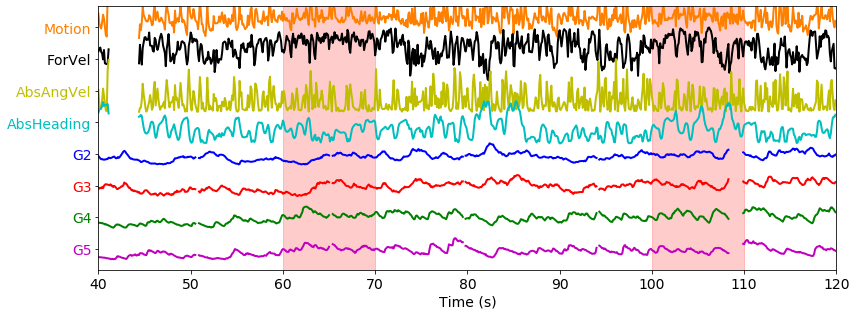

In [3]:
fig_size = (12, 4.5)
font_size = 14
trial = trials[2]
t_wdw = (40, 120)
vs = ['G2', 'G3', 'G4', 'G5']

fig, ax = plt.subplots(1, 1, figsize=fig_size, tight_layout=True)

t = data_n[trial]['Time']
t_mask = (t_wdw[0] <= t) & (t < t_wdw[1])

motion = data_n[trial]['Motion'][t_mask]
motion -= motion.min()
motion /= (.4 * motion.max())

ax.plot(t[t_mask], motion - 1.5, lw=2, c=COLORS['Motion'])

for_vel = data_n[trial]['ForVel'][t_mask]
for_vel -= for_vel.min()
for_vel /= (.4 * for_vel.max())

ax.plot(t[t_mask], for_vel - 3.5, lw=2, c=COLORS['ForVel'])

abs_ang_vel = data_n[trial]['AbsAngVel'][t_mask]
abs_ang_vel -= abs_ang_vel.min()
abs_ang_vel /= (.4 * abs_ang_vel.max())

ax.plot(t[t_mask], abs_ang_vel - 5, lw=2, c=COLORS['AbsAngVel'])

abs_heading = data_n[trial]['AbsHeading'][t_mask].copy()
abs_heading -= abs_heading.min()
abs_heading /= (.5 * abs_heading.max())

ax.plot(t[t_mask], abs_heading - 6.5, lw=2, c=COLORS['AbsHeading'])

offsets = [-1.5, -3, -4.5, -6]

for v_ctr, v in enumerate(vs):
    x = data_n[trial][v][t_mask]
    x -= x.min()
    x /= x.max()
    
    offset = -(v_ctr + 5)*1.5
    ax.plot(t[t_mask], x + offset, lw=2, c=COLORS[v])

    offsets.append(offset)
    
offsets = np.array(offsets)

df_odor = d_odor[trial]

for r_ctr, r in df_odor.iterrows():
    start = r['Odor_On']
    stop = r['Odor_Off']
    if CTL_T_OFFSET == 0:
        ax.axvspan(start, stop, color='r', alpha=0.2)
    else:
        ax.axvspan(start, stop, color='gray', alpha=0.2)
        

ax.set_xlim(t_wdw)
ax.set_ylim(-12.5, 0)
ax.set_yticks(offsets + 0.5)
ax.set_yticklabels(['Motion', 'ForVel', 'AbsAngVel', 'AbsHeading'] + vs)

for y_tick, v in zip(ax.get_yticklabels(), ['Motion', 'ForVel', 'AbsAngVel', 'AbsHeading'] + vs):
    y_tick.set_color(COLORS[v])

ax.set_xlabel('Time (s)')

set_font_size(ax, font_size)

# Peristimulus responses

/home/z051m/miniconda3/envs/sci/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


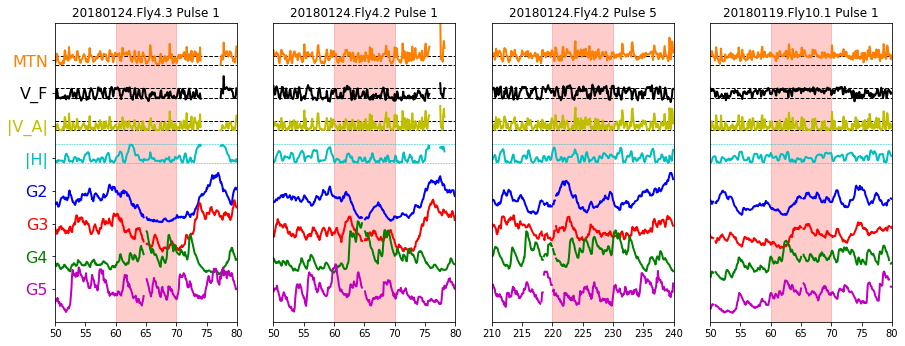

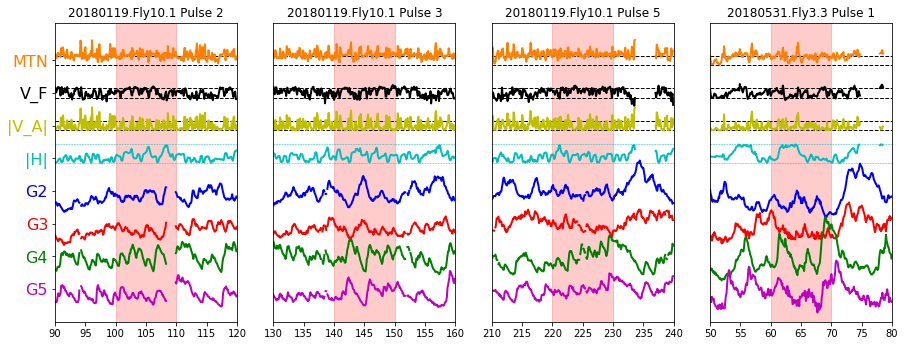

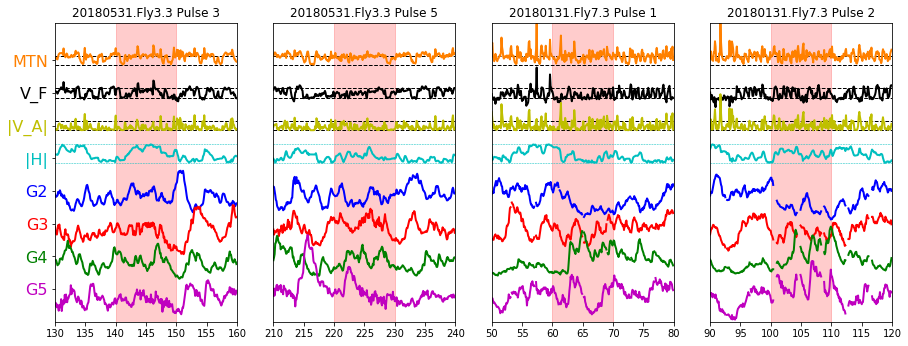

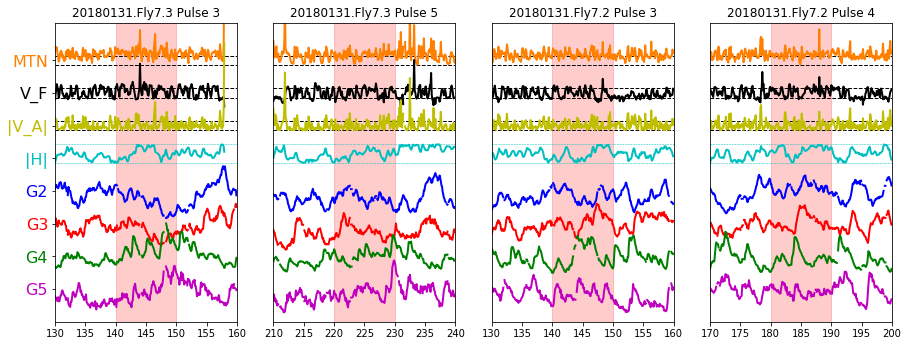

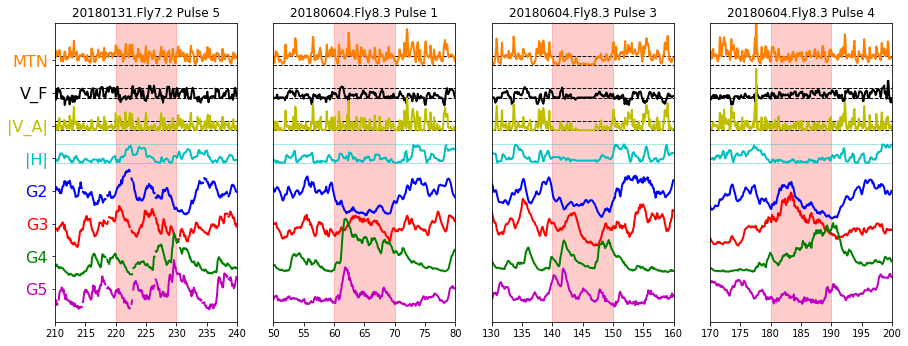

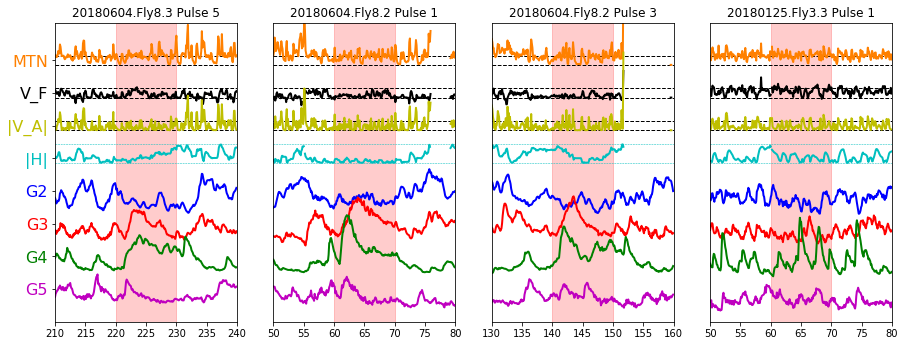

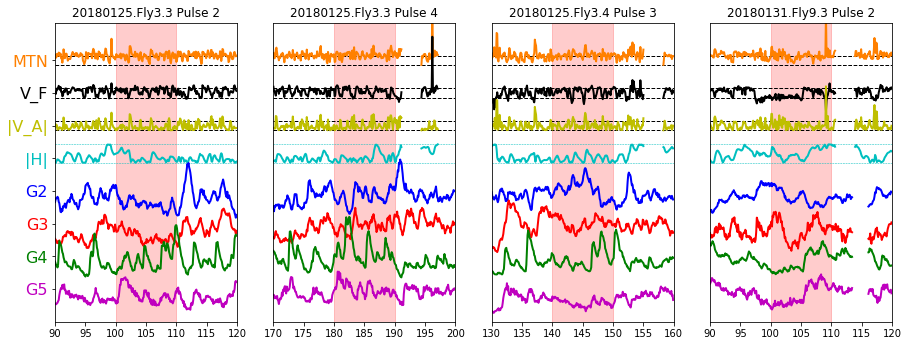

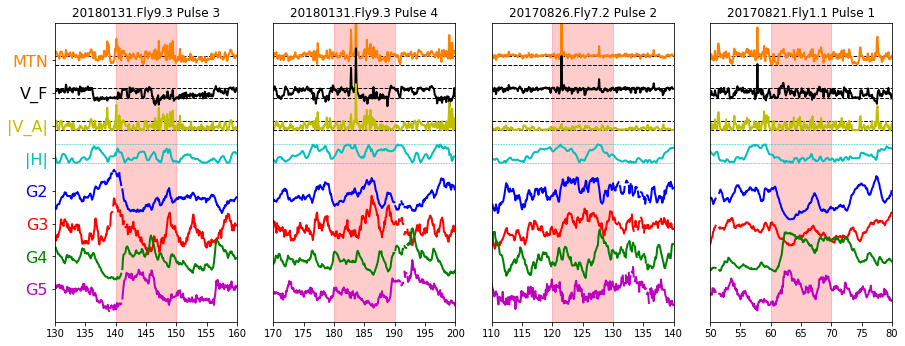

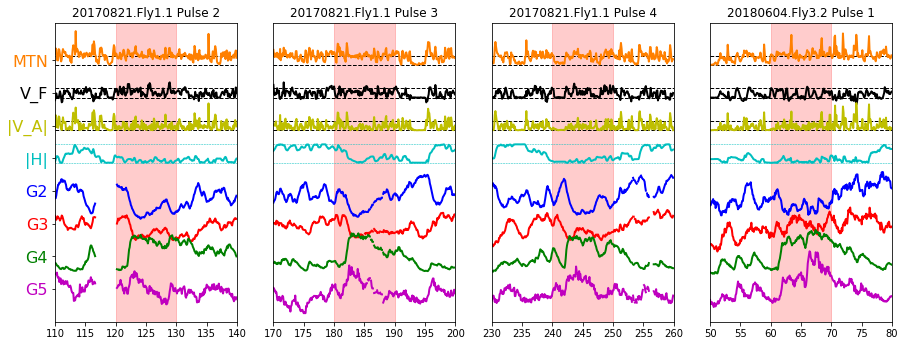

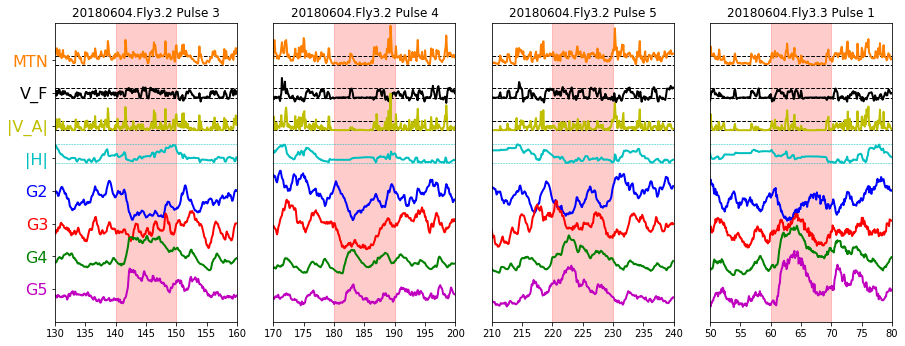

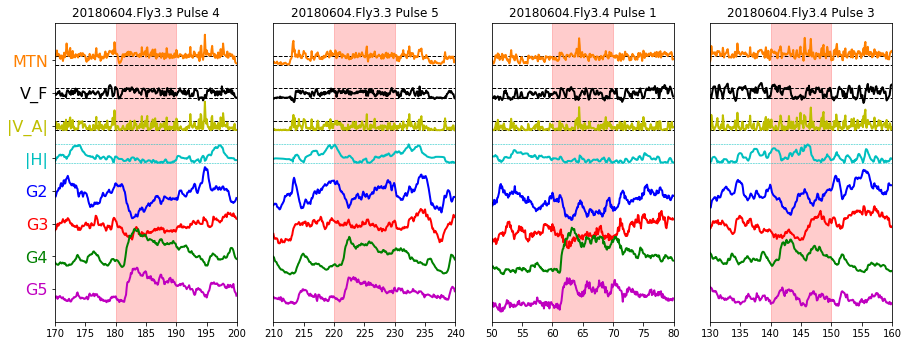

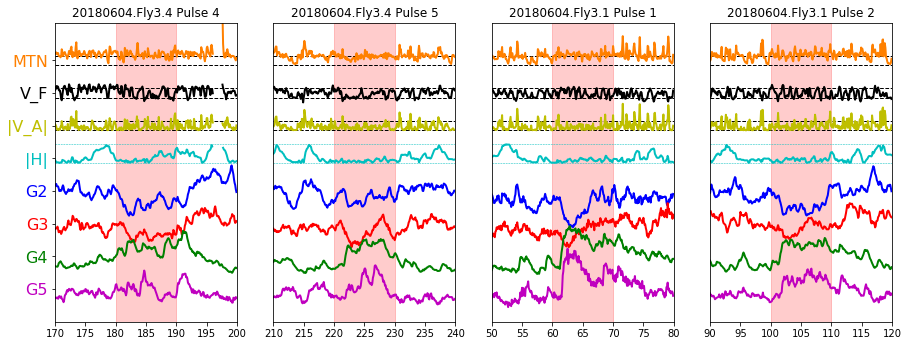

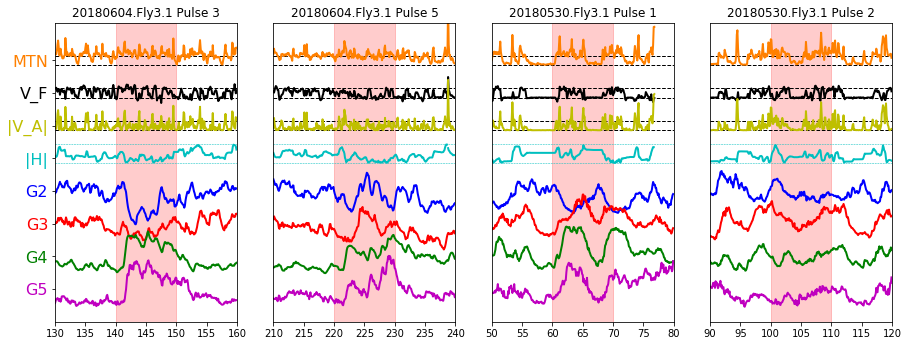

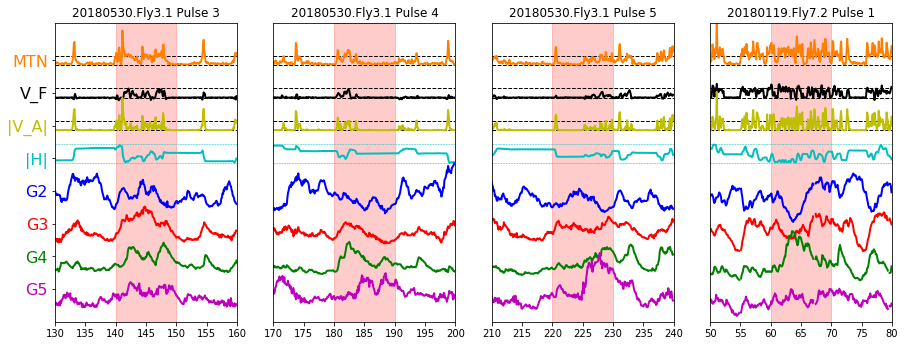

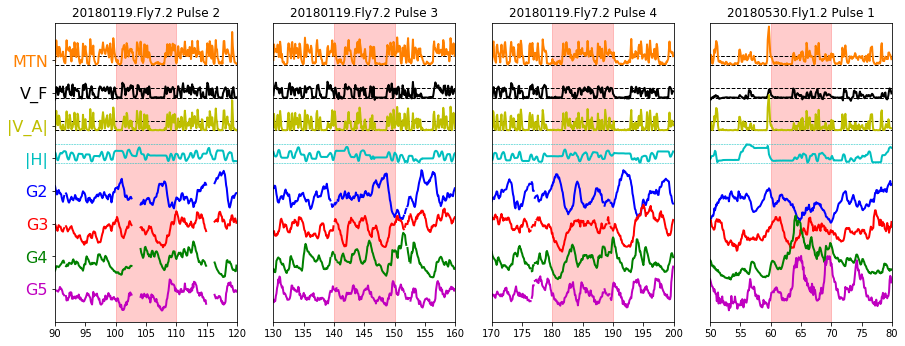

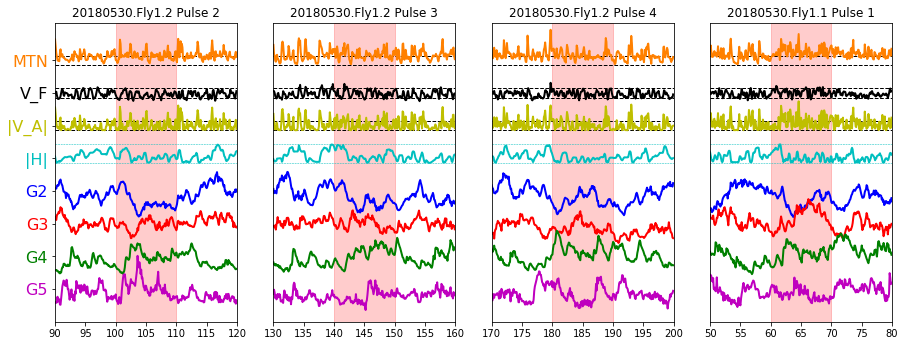

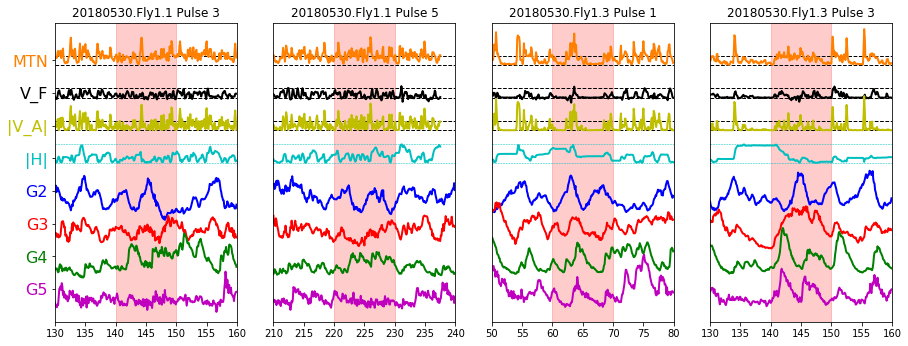

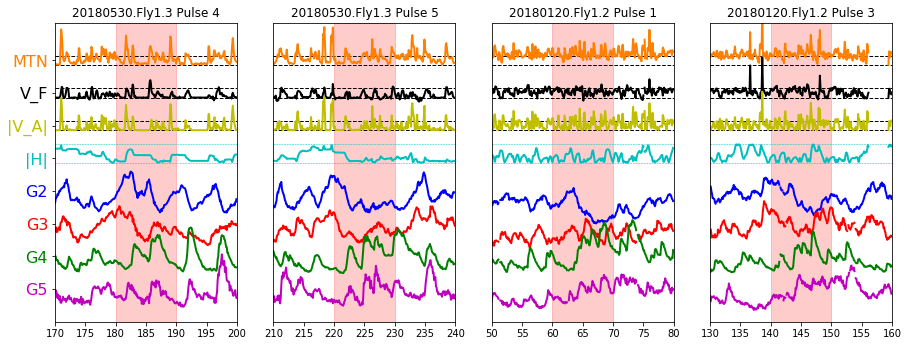

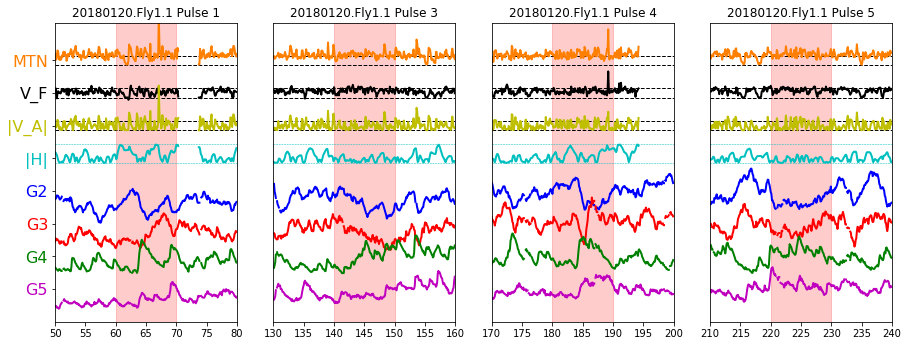

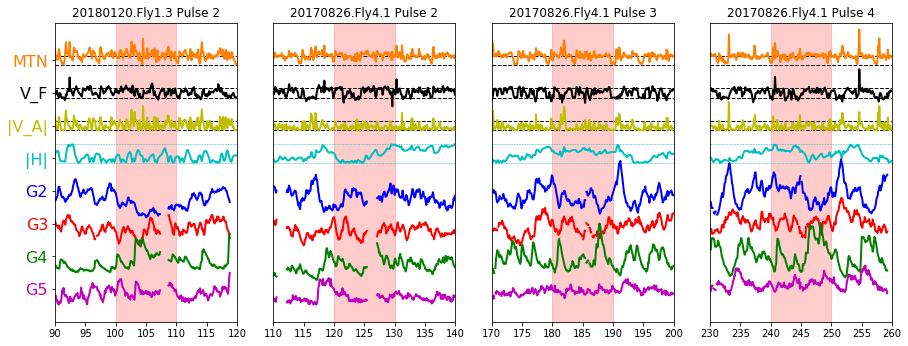

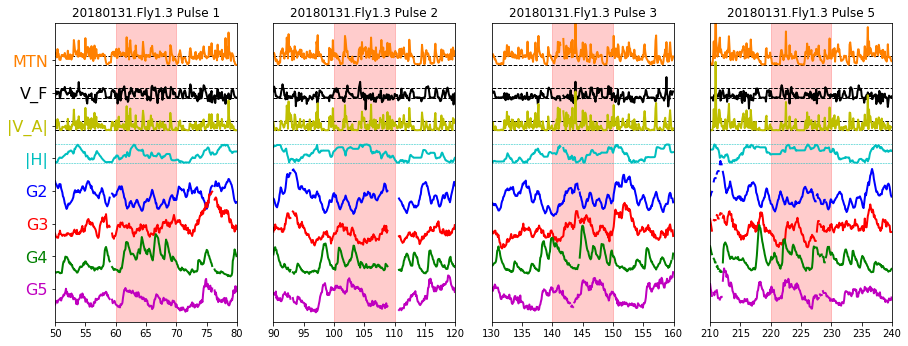

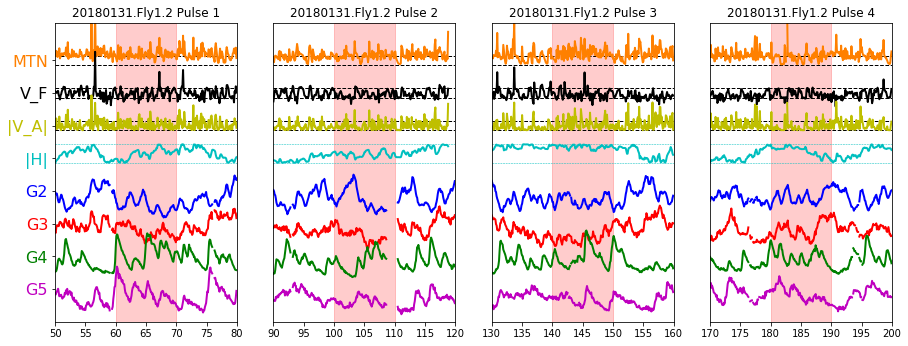

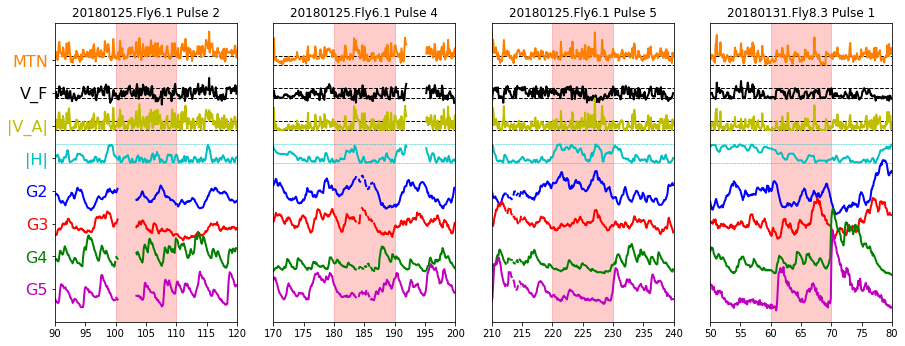

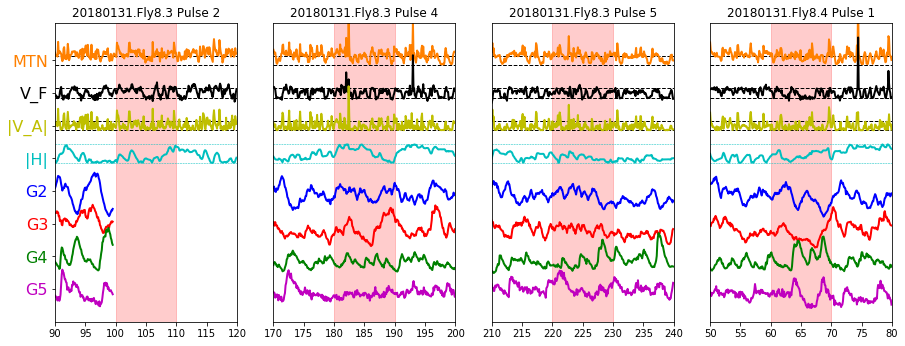

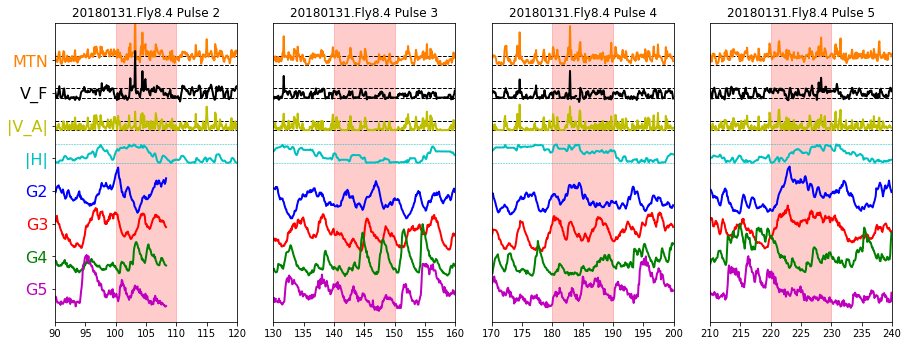

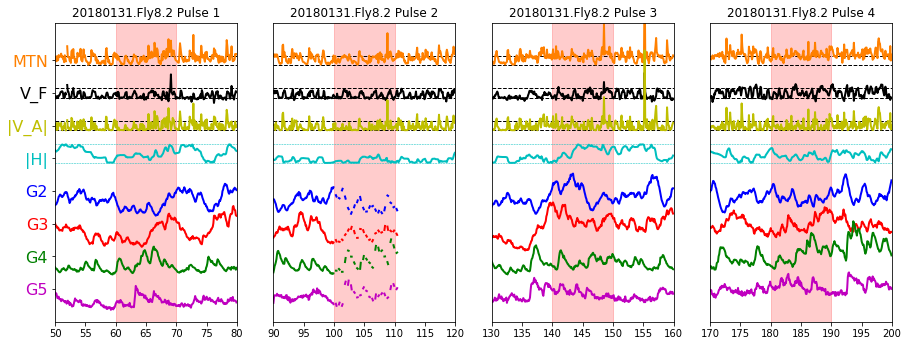

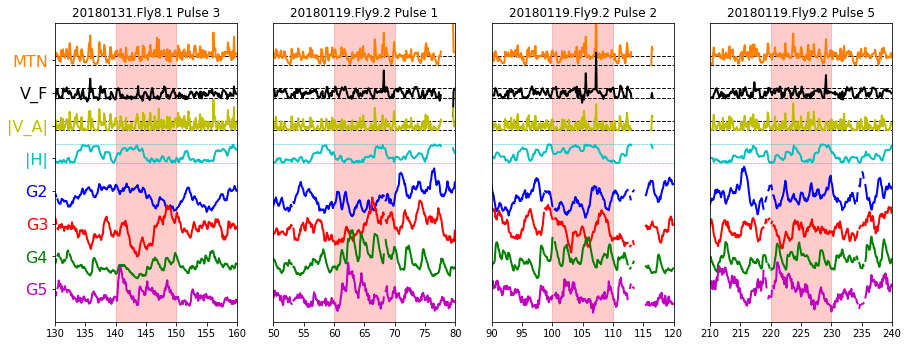

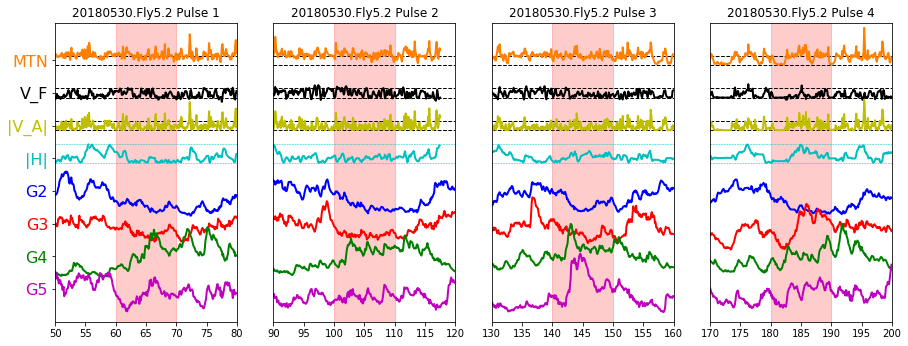

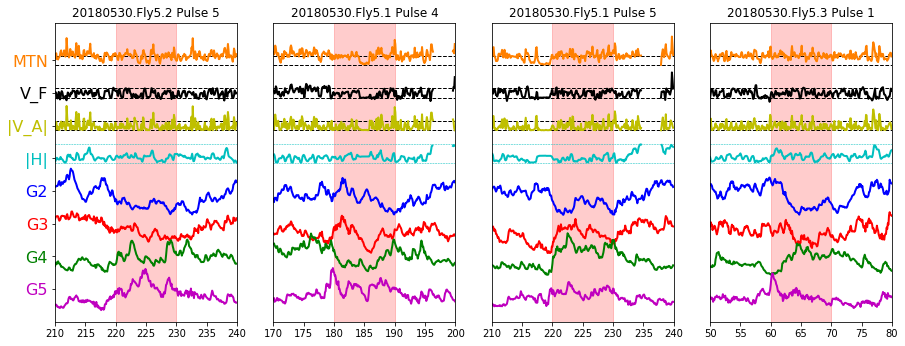

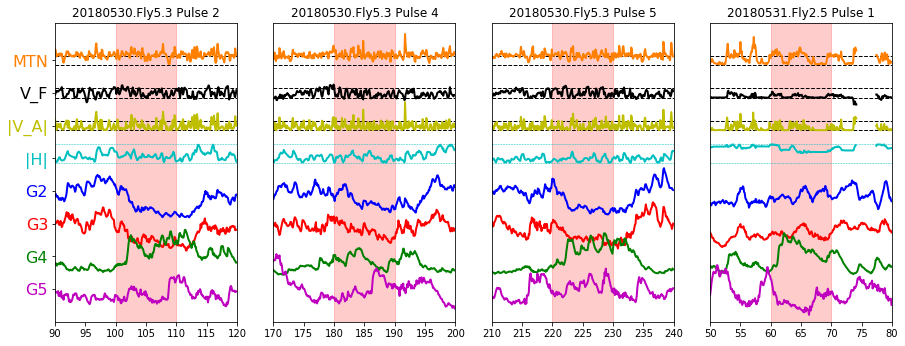

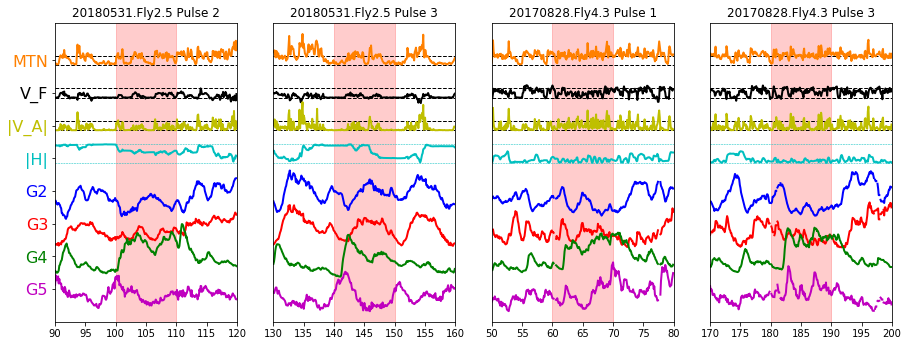

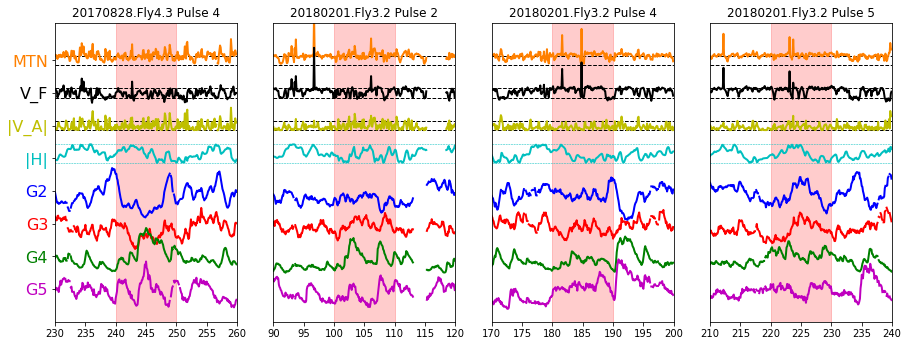

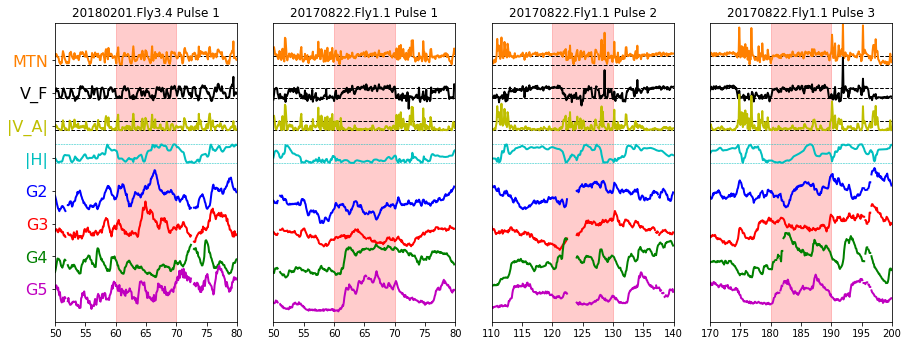

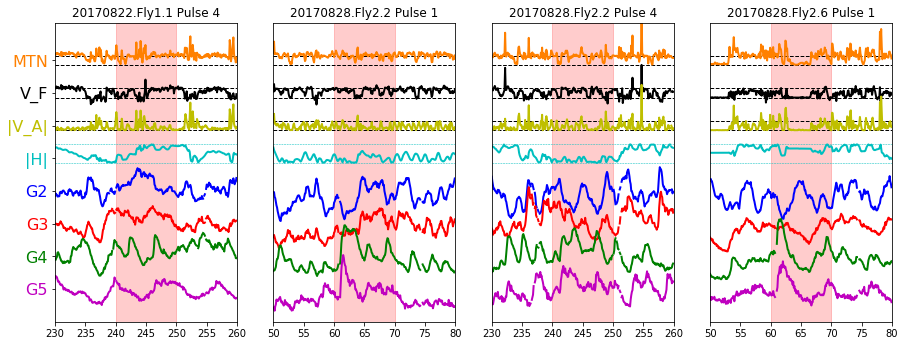

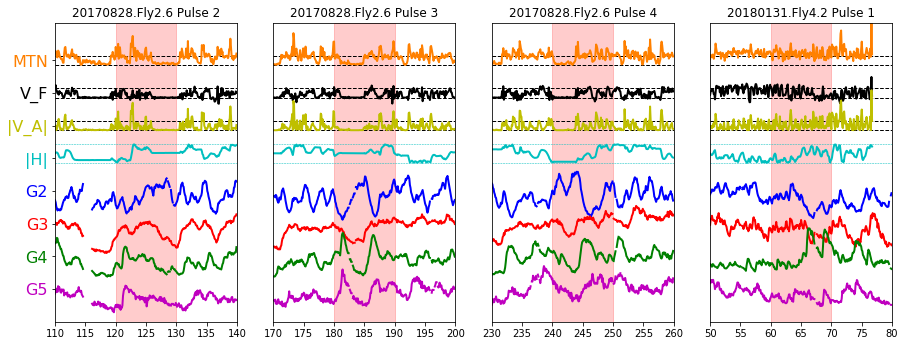

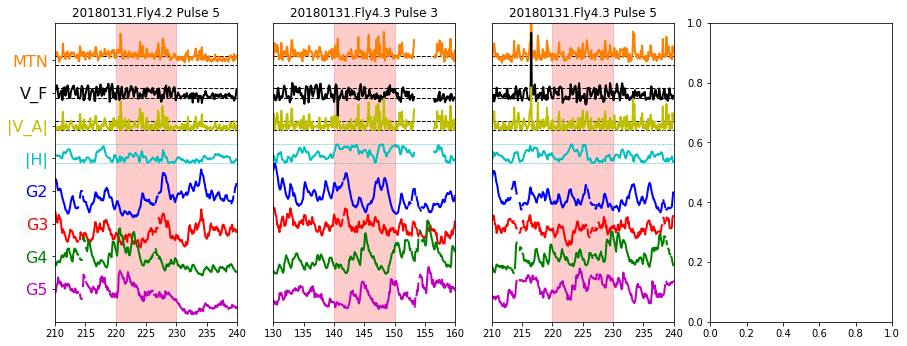

In [4]:
T_WDW_PST = [-10., 20.]
VS_PST = ['Motion', 'ForVel', 'AbsAngVel', 'AbsHeading', 'G2', 'G3', 'G4', 'G5']
LABELS = ['MTN', 'V_F', '|V_A|', '|H|', 'G2', 'G3', 'G4', 'G5']
PULSE_RANGE = [0, n_pulse]
N_COL = 4
FIG_SIZE = (15, 5.5)
Y_LIM = (-28, 4)

n_pulses = PULSE_RANGE[1] - PULSE_RANGE[0]
n_fig = int(np.ceil(n_pulses/N_COL))

p_ctr = 0

odor_trig_data = {v: [] for v in ['Time'] + VS_PST}

for fig_ctr in range(n_fig):
    fig, axs = plt.subplots(1, N_COL, figsize=FIG_SIZE)
    axs = axs.flatten()
    
    for p_id in range(p_ctr, min(p_ctr+N_COL, n_pulses)):
        
        ax = axs[p_id - p_ctr]
        trial = df_pulse.iloc[p_id]['Trial']
        pulse = df_pulse.iloc[p_id]['Pulse']
        start = df_pulse.iloc[p_id]['Start']
        stop = df_pulse.iloc[p_id]['Stop']
        t_mask = (start + T_WDW_PST[0] <= data_n[trial]['Time']) & (data_n[trial]['Time'] < start + T_WDW_PST[1])
        
        t = data_n[trial]['Time'][t_mask]
        
        odor_trig_data['Time'].append(np.array(t))
        
        # plot all vars
        offsets = []
        
        for v_ctr, v in enumerate(VS_PST):
            offset = -v_ctr*3.5
            v_vals = data_n[trial][v][t_mask].copy()
            
            if v in ['Motion', 'ForVel', 'AbsAngVel']:
                ax.axhline(offset-.5, lw=1, ls='--', alpha=1, color='k')
                ax.axhline(offset+.5, lw=1, ls='--', alpha=1, color='k')
                ax.plot(t, v_vals + offset-.5, color=COLORS[v], lw=2)
                
            elif v == 'AbsHeading':
                ax.axhline(offset-.5, lw=.5, ls='--', alpha=1, color=COLORS[v])
                ax.axhline(offset+1.5, lw=.5, ls='--', alpha=1, color=COLORS[v]) 
                ax.plot(t, v_vals/(np.pi/2) + offset-.5, color=COLORS[v], lw=2)
                
            else:
                ax.plot(t, v_vals + offset-.5, color=COLORS[v], lw=2)
            
            odor_trig_data[v].append(np.array(v_vals))
            
            offsets.append(offset)
        
        if CTL_T_OFFSET:
            c_odor = 'gray'
        else:
            c_odor = 'r'
            
        if EXPT.startswith('CL_360_LOWFLOW_ACV'):
            ax.axvspan(start, stop, color=c_odor, alpha=0.2)
        elif EXPT == 'CL_180_HighFlow_ACV':
            ax.axvspan(start, stop, color=c_odor, alpha=0.2)
            
        ax.set_xlim(start + T_WDW_PST[0], start + T_WDW_PST[1])
        ax.set_ylim(Y_LIM)
        
        if p_ctr == p_id:
            ax.set_yticks(offsets)
            ax.set_yticklabels(LABELS)
            
            for y_tick, v in zip(ax.get_yticklabels(), ['Motion', 'ForVel', 'AbsAngVel', 'AbsHeading'] + vs):
                y_tick.set_color(COLORS[v])
                y_tick.set_fontsize(16)
        else:
            ax.yaxis.set_visible(False)
            
        ax.set_title('{} Pulse {}'.format(trial, pulse+1))
        
    p_ctr += N_COL

Save

In [5]:
if CTL_T_OFFSET == 0:
    base = '{}_DATA.npy'.format(EXPT)
else:
    base = '{}_DATA_CTL.npy'.format(EXPT)
    
np.save(os.path.join(SAVE_DIR, base), np.array([{'data': odor_trig_data}]))

# Statistics

Odor-triggered ensembles

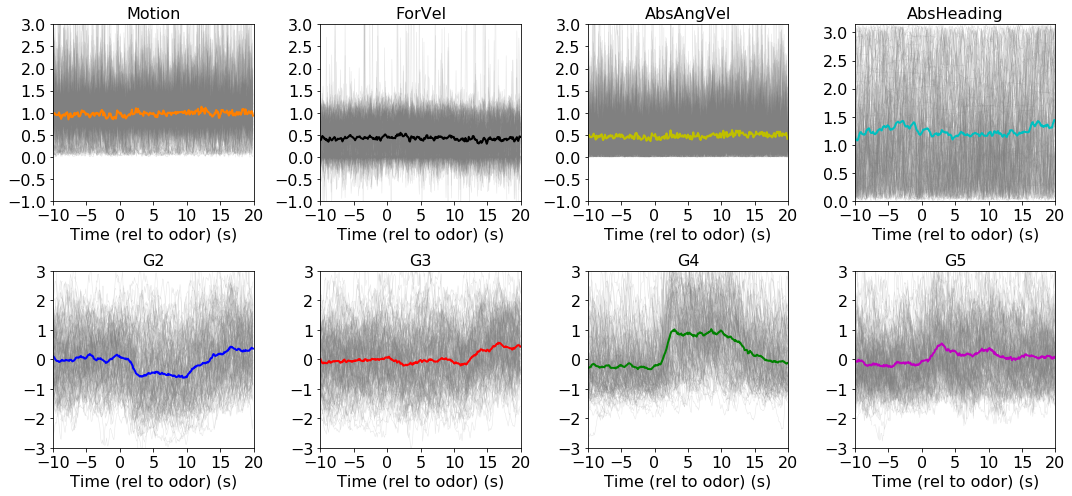

In [6]:
VS_PST = ['Motion', 'ForVel', 'AbsAngVel', 'AbsHeading', 'G2', 'G3', 'G4', 'G5']
Y_LIM = {
    'Motion': (-1, 3), 'ForVel': (-1, 3), 'AbsAngVel': (-1, 3), 'AbsHeading': (0, np.pi),
    'G2': (-3, 3), 'G3': (-3, 3), 'G4': (-3, 3), 'G5': (-3, 3)
}

fig, axs = plt.subplots(2, 4, figsize=(15, 7), tight_layout=True)
axs = axs.flatten()

for v, ax in zip(VS_PST, axs):
    t = odor_trig_data['Time'][0]
    t -= t[0]
    t += T_WDW_PST[0]
    
    v_vals = np.array(odor_trig_data[v])
    
    ax.plot(t, v_vals.T, color='gray', lw=.5, alpha=.2)
    
    ax.plot(t, np.nanmean(v_vals, 0), color=COLORS[v], lw=2)
    
    if EXPT == 'CL_360_LOWFLOW_ACV_2':
        start = 0
        stop = 10
    elif EXPT == 'CL_180_HighFlow_ACV':
        start = 0
        stop = 60
    
    if CTL_T_OFFSET == 0:
        ax.axvspan(start, stop, color='r', alpha=0.2)
    else:
        ax.axvspan(start, stop, color='gray', alpha=0.2)
        
    ax.set_xlim(T_WDW_PST)
    ax.set_ylim(Y_LIM[v])
    ax.set_xlabel('Time (rel to odor) (s)')
    ax.set_title(v)
    
for ax in axs:
    set_font_size(ax, 16)

Odor/non-odor heading histograms

All time points

117995 G4 non-odor points
22652 G4 odor points
110532 heading non-odor points
21671 heading odor points


/home/z051m/miniconda3/envs/sci/lib/python3.6/site-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/z051m/miniconda3/envs/sci/lib/python3.6/site-packages/ipykernel_launcher.py:33: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/z051m/miniconda3/envs/sci/lib/python3.6/site-packages/ipykernel_launcher.py:37: VisibleDeprecationWarning: Passing `normed=Tru

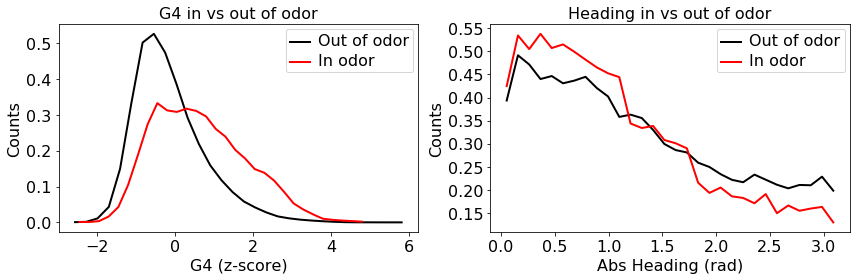

In [7]:
all_g4_non_odor = []
all_g4_odor = []

all_abs_head_non_odor = []
all_abs_head_odor = []

for trial, odor_mask, mvng_mask in zip(trials, odor_masks, mvng_masks):
    data_n_ = data_n[trial]
    
    all_g4_odor.extend(data_n_['G4'][odor_mask])
    all_g4_non_odor.extend(data_n_['G4'][(~odor_mask)])
    
    all_abs_head_odor.extend(data_n_['AbsHeading'][odor_mask])
    all_abs_head_non_odor.extend(data_n_['AbsHeading'][(~odor_mask)])

all_g4_non_odor = np.array(all_g4_non_odor)
all_g4_odor = np.array(all_g4_odor)

all_g4_non_odor = all_g4_non_odor[~np.isnan(all_g4_non_odor)]
all_g4_odor = all_g4_odor[~np.isnan(all_g4_odor)]

all_abs_head_non_odor = np.array(all_abs_head_non_odor)
all_abs_head_odor = np.array(all_abs_head_odor)

all_abs_head_non_odor = all_abs_head_non_odor[~np.isnan(all_abs_head_non_odor)]
all_abs_head_odor = all_abs_head_odor[~np.isnan(all_abs_head_odor)]

print('{} G4 non-odor points'.format(len(all_g4_non_odor)))
cts_g4_non_odor, bins_g4_non_odor = np.histogram(all_g4_non_odor, bins=30, normed=True)
bincs_g4_non_odor = .5*(bins_g4_non_odor[:-1] + bins_g4_non_odor[1:])

print('{} G4 odor points'.format(len(all_g4_odor)))
cts_g4_odor, bins_g4_odor = np.histogram(all_g4_odor, bins=30, normed=True)
bincs_g4_odor = .5*(bins_g4_odor[:-1] + bins_g4_odor[1:])

print('{} heading non-odor points'.format(len(all_abs_head_non_odor)))
cts_abs_head_non_odor, bins_abs_head_non_odor = np.histogram(all_abs_head_non_odor, bins=np.linspace(0, np.pi, 31), normed=True)
bincs_abs_head_non_odor = .5*(bins_abs_head_non_odor[:-1] + bins_abs_head_non_odor[1:])

print('{} heading odor points'.format(len(all_abs_head_odor)))
cts_abs_head_odor, bins_abs_head_odor = np.histogram(all_abs_head_odor, bins=np.linspace(0, np.pi, 31), normed=True)
bincs_abs_head_odor = .5*(bins_abs_head_odor[:-1] + bins_abs_head_odor[1:])

fig, axs = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)
axs[0].plot(bincs_g4_non_odor, cts_g4_non_odor, lw=2, c='k')
axs[0].plot(bincs_g4_odor, cts_g4_odor, lw=2, c='r')
axs[0].set_xlabel('G4 (z-score)')
axs[0].set_ylabel('Counts')
axs[0].set_title('G4 in vs out of odor')
axs[0].legend(['Out of odor', 'In odor'])

axs[1].plot(bincs_abs_head_non_odor, cts_abs_head_non_odor, lw=2, c='k')
axs[1].plot(bincs_abs_head_odor, cts_abs_head_odor, lw=2, c='r')
axs[1].set_xlabel('Abs Heading (rad)')
axs[1].set_ylabel('Counts')
axs[1].set_title('Heading in vs out of odor')
axs[1].legend(['Out of odor', 'In odor'])

for ax in axs:
    set_font_size(ax, 16)

Only active locomotion timepoints

105100 G4 non-odor points
20881 G4 odor points
97419 heading non-odor points
19870 heading odor points


/home/z051m/miniconda3/envs/sci/lib/python3.6/site-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/z051m/miniconda3/envs/sci/lib/python3.6/site-packages/ipykernel_launcher.py:33: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/z051m/miniconda3/envs/sci/lib/python3.6/site-packages/ipykernel_launcher.py:37: VisibleDeprecationWarning: Passing `normed=Tru

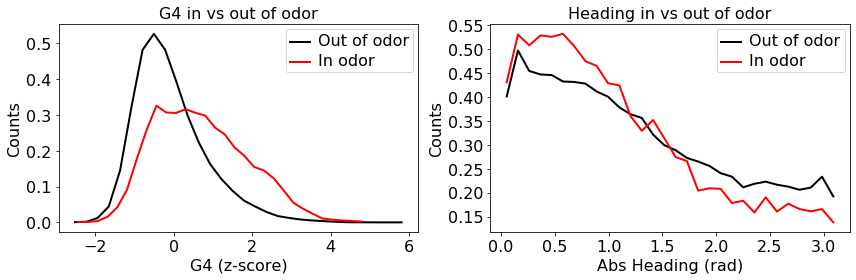

In [8]:
all_g4_non_odor = []
all_g4_odor = []

all_abs_head_non_odor = []
all_abs_head_odor = []

for trial, odor_mask, mvng_mask in zip(trials, odor_masks, mvng_masks):
    data_n_ = data_n[trial]
    
    all_g4_odor.extend(data_n_['G4'][odor_mask & mvng_mask])
    all_g4_non_odor.extend(data_n_['G4'][(~odor_mask) & mvng_mask])
    
    all_abs_head_odor.extend(data_n_['AbsHeading'][odor_mask & mvng_mask])
    all_abs_head_non_odor.extend(data_n_['AbsHeading'][(~odor_mask) & mvng_mask])

all_g4_non_odor = np.array(all_g4_non_odor)
all_g4_odor = np.array(all_g4_odor)

all_g4_non_odor = all_g4_non_odor[~np.isnan(all_g4_non_odor)]
all_g4_odor = all_g4_odor[~np.isnan(all_g4_odor)]

all_abs_head_non_odor = np.array(all_abs_head_non_odor)
all_abs_head_odor = np.array(all_abs_head_odor)

all_abs_head_non_odor = all_abs_head_non_odor[~np.isnan(all_abs_head_non_odor)]
all_abs_head_odor = all_abs_head_odor[~np.isnan(all_abs_head_odor)]

print('{} G4 non-odor points'.format(len(all_g4_non_odor)))
cts_g4_non_odor, bins_g4_non_odor = np.histogram(all_g4_non_odor, bins=30, normed=True)
bincs_g4_non_odor = .5*(bins_g4_non_odor[:-1] + bins_g4_non_odor[1:])

print('{} G4 odor points'.format(len(all_g4_odor)))
cts_g4_odor, bins_g4_odor = np.histogram(all_g4_odor, bins=30, normed=True)
bincs_g4_odor = .5*(bins_g4_odor[:-1] + bins_g4_odor[1:])

print('{} heading non-odor points'.format(len(all_abs_head_non_odor)))
cts_abs_head_non_odor, bins_abs_head_non_odor = np.histogram(all_abs_head_non_odor, bins=np.linspace(0, np.pi, 31), normed=True)
bincs_abs_head_non_odor = .5*(bins_abs_head_non_odor[:-1] + bins_abs_head_non_odor[1:])

print('{} heading odor points'.format(len(all_abs_head_odor)))
cts_abs_head_odor, bins_abs_head_odor = np.histogram(all_abs_head_odor, bins=np.linspace(0, np.pi, 31), normed=True)
bincs_abs_head_odor = .5*(bins_abs_head_odor[:-1] + bins_abs_head_odor[1:])

fig, axs = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)
axs[0].plot(bincs_g4_non_odor, cts_g4_non_odor, lw=2, c='k')
axs[0].plot(bincs_g4_odor, cts_g4_odor, lw=2, c='r')
axs[0].set_xlabel('G4 (z-score)')
axs[0].set_ylabel('Counts')
axs[0].set_title('G4 in vs out of odor')
axs[0].legend(['Out of odor', 'In odor'])

axs[1].plot(bincs_abs_head_non_odor, cts_abs_head_non_odor, lw=2, c='k')
axs[1].plot(bincs_abs_head_odor, cts_abs_head_odor, lw=2, c='r')
axs[1].set_xlabel('Abs Heading (rad)')
axs[1].set_ylabel('Counts')
axs[1].set_title('Heading in vs out of odor')
axs[1].legend(['Out of odor', 'In odor'])

for ax in axs:
    set_font_size(ax, 16)